In [1]:
!pip install -q mlflow databricks-sdk


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import mlflow
from mlflow import spark

# Configurar el experimento en MLflow
mlflow.set_experiment('/Users/andrescandelo17@gmail.com/wine-classification-experiment')


<Experiment: artifact_location='file:///c:/Users/andre/OneDrive/Desktop/PRUEBAS%20PYTHON/GLOBAL/mlruns/650572817988477050', creation_time=1724336345108, experiment_id='650572817988477050', last_update_time=1724336345108, lifecycle_stage='active', name='/Users/andrescandelo17@gmail.com/wine-classification-experiment', tags={}>

In [4]:
import urllib.request

# URL del archivo de datos
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
local_filename = "wine.data"

# Descargar el archivo
urllib.request.urlretrieve(url, local_filename)
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder.appName("WineData").getOrCreate()


In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

# Crear una sesión de Spark
spark = SparkSession.builder.appName("WineData").getOrCreate()

# Leer el archivo CSV localmente usando PySpark
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
local_filename = "wine.data"
df = spark.read.csv(local_filename, inferSchema=True, header=False)

# Asignar nombres de columnas
column_names = [
    "Class", "Alcohol", "Malic_acid", "Ash", "Alcalinity_of_ash", "Magnesium",
    "Total_phenols", "Flavanoids", "Nonflavanoid_phenols", "Proanthocyanins",
    "Color_intensity", "Hue", "OD280/OD315_of_diluted_wines", "Proline"
]
for old_name, new_name in zip(df.columns, column_names):
    df = df.withColumnRenamed(old_name, new_name)

# Preparar los datos
assembler = VectorAssembler(inputCols=column_names[1:], outputCol="features")
df = assembler.transform(df)


# Dividir el DataFrame en entrenamiento y prueba
train_df, test_df = df.randomSplit([0.8, 0.2])


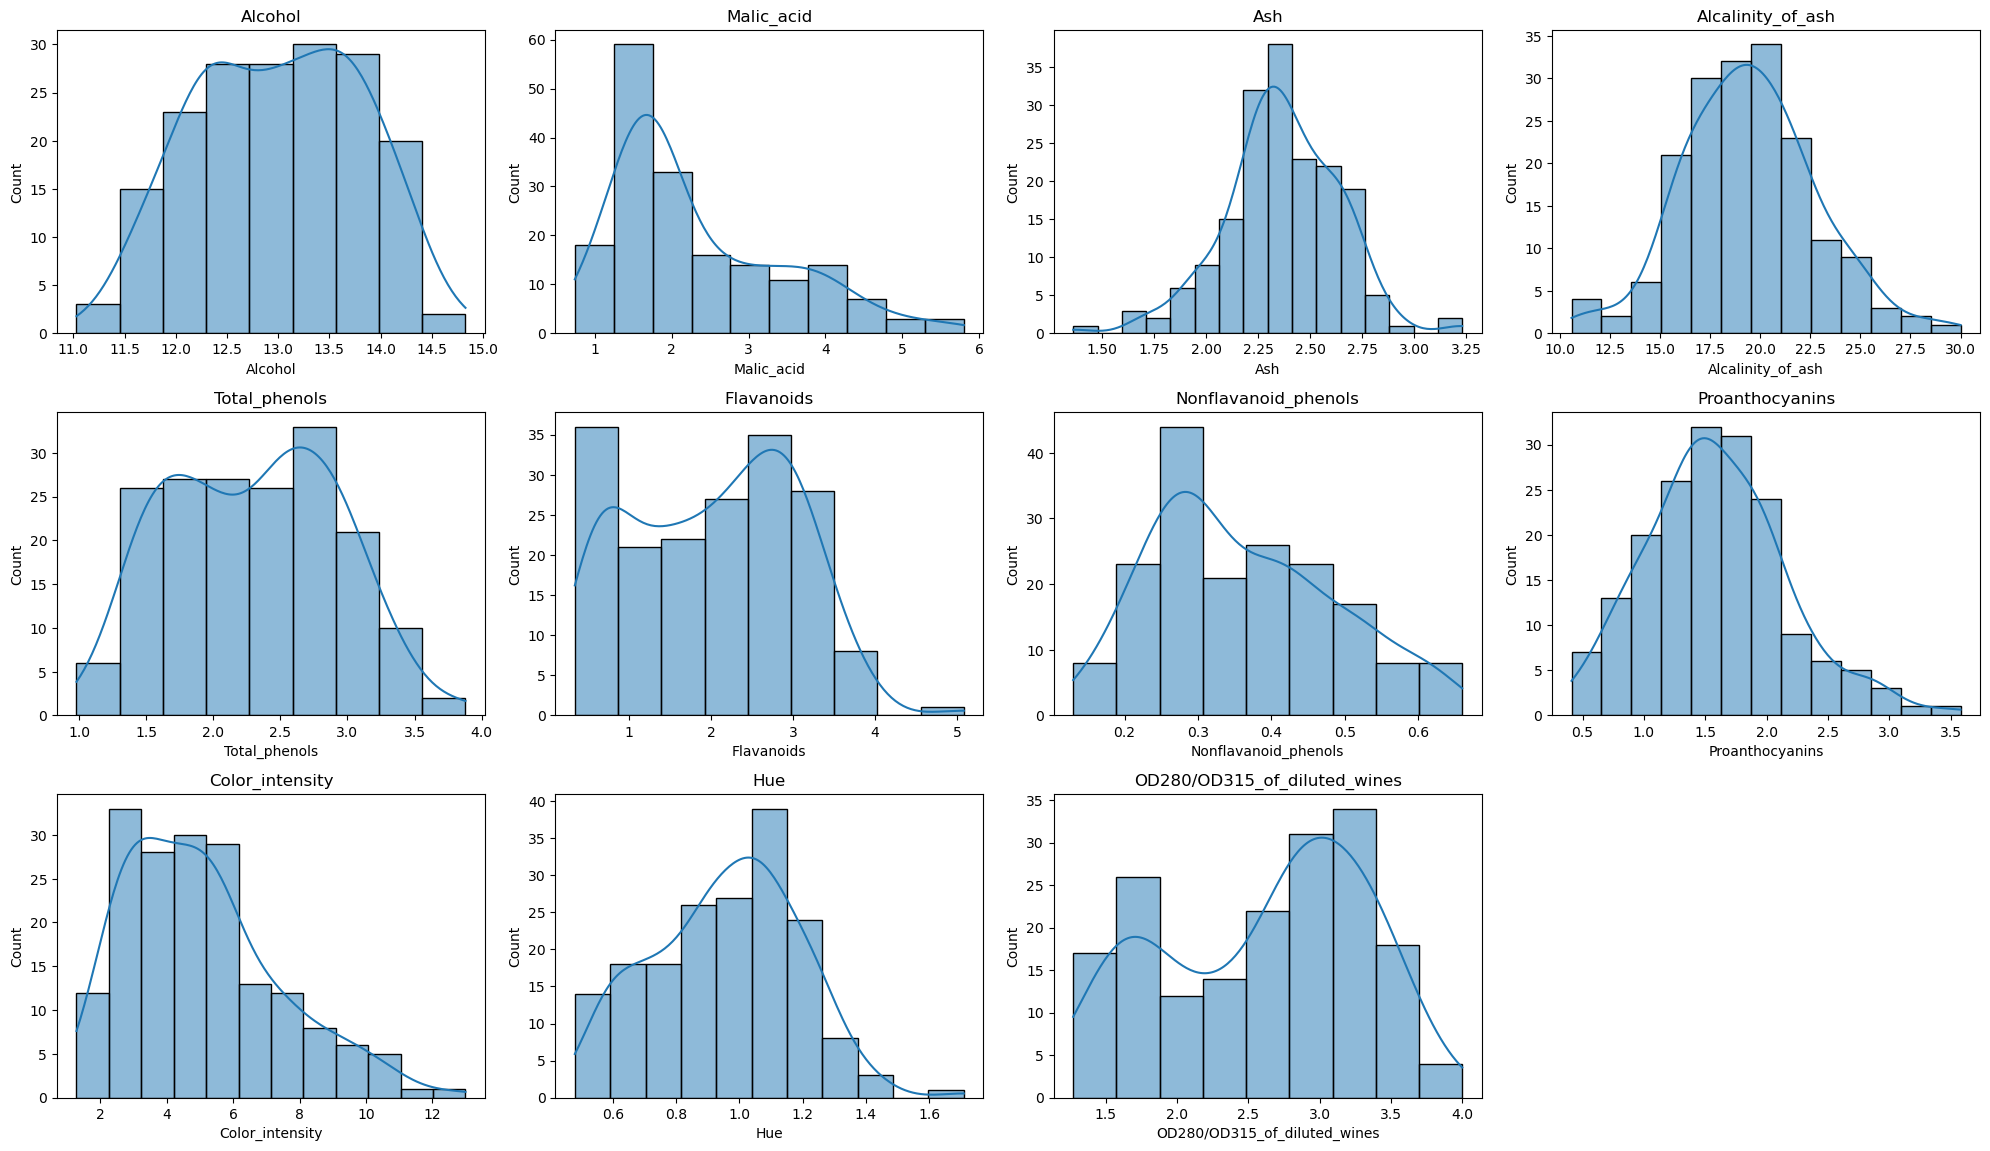

In [6]:
# Convertir el DataFrame de PySpark a un DataFrame de Pandas
pandas_df = df.toPandas()
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar solo las columnas numéricas
numeric_columns = pandas_df.select_dtypes(include=['float64', 'int64']).columns

# Definir el tamaño del gráfico
plt.figure(figsize=(20, 15))

# Iterar sobre cada columna para graficar
for i, column in enumerate(numeric_columns):  # Usando solo columnas numéricas
    plt.subplot(4, 4, i+1)
    sns.histplot(pandas_df[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()



In [7]:
pandas_df.dtypes

Class                             int32
Alcohol                         float64
Malic_acid                      float64
Ash                             float64
Alcalinity_of_ash               float64
Magnesium                         int32
Total_phenols                   float64
Flavanoids                      float64
Nonflavanoid_phenols            float64
Proanthocyanins                 float64
Color_intensity                 float64
Hue                             float64
OD280/OD315_of_diluted_wines    float64
Proline                           int32
features                         object
dtype: object

In [8]:
pandas_df.isna().sum()

Class                           0
Alcohol                         0
Malic_acid                      0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
OD280/OD315_of_diluted_wines    0
Proline                         0
features                        0
dtype: int64

In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import mlflow
import mlflow.spark


# Evaluador para F1 Score
evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")

# Random Forest
rf = RandomForestClassifier(labelCol="Class", featuresCol="features")
rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [10, 50])
                 .addGrid(rf.maxDepth, [5, 10])
                 .build())
cv_rf = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator,
                       numFolds=5)

# Regresión Logística
lr = LogisticRegression(labelCol="Class", featuresCol="features", maxIter=10)
lr_param_grid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.1, 0.01])
                 .addGrid(lr.elasticNetParam, [0.8, 0.5])
                 .build())
cv_lr = CrossValidator(estimator=lr,
                       estimatorParamMaps=lr_param_grid,
                       evaluator=evaluator,
                       numFolds=5)



# Ajustar modelos
cv_rf_model = cv_rf.fit(train_df)
cv_lr_model = cv_lr.fit(train_df)

# Evaluar modelos
def evaluate_model(model, test_df):
    predictions = model.transform(test_df)
    f1_score = evaluator.evaluate(predictions)
    return f1_score

In [20]:
import mlflow

mlflow.login()

# Configurar el experimento en MLflow
mlflow.set_experiment('/Users/andrescandelo17@gmail.com/wine-classification-experiment')


2024/08/22 11:31:16 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1363496029402307', creation_time=1724280100848, experiment_id='1363496029402307', last_update_time=1724344260729, lifecycle_stage='active', name='/Users/andrescandelo17@gmail.com/wine-classification-experiment', tags={'mlflow.experiment.sourceName': '/Users/andrescandelo17@gmail.com/wine-classification-experiment',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'andrescandelo17@gmail.com',
 'mlflow.ownerId': '7803580858861557'}>

In [26]:
# Configuración del experimento
mlflow.set_experiment('/Users/andrescandelo17@gmail.com/wine-classification-experiment')

class SparkModelWrapper(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        self.model = context.artifacts['model']  # Asegúrate de cargar el modelo

    def predict(self, context, model_input):
        return self.model.transform(model_input)

def log_model_with_mlflow(model, model_name):
    # Terminar cualquier ejecución activa
    if mlflow.active_run() is not None:
        mlflow.end_run()
    
    with mlflow.start_run():
        mlflow.log_param("model", model_name)
        f1_score = evaluate_model(model, test_df)
        mlflow.log_metric("f1_score", f1_score)
        
        mlflow.pyfunc.log_model(
            artifact_path=model_name,
            python_model=SparkModelWrapper()
        )

# Registrar los modelos entrenados
log_model_with_mlflow(cv_rf_model.bestModel, "rf-model")
log_model_with_mlflow(cv_lr_model.bestModel, "lr-model")


2024/08/22 11:36:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\andre\AppData\Local\Temp\tmpcp9c6w5t\model, flavor: python_function). Fall back to return ['cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
c:\Users\andre\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/08/22 11:36:54 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.15.1/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

2024/08/22 11:36:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/22 11:36:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run smiling-panda-795 at: https://community.cloud.databricks.com/ml/experiments/1363496029402307/runs/be2c052e19ba4827aee8d3ba84ef2522.
2024/08/22 11:36:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1363496029402307.
2024/08/22 11:37:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\andre\AppData\Local\Temp\tmpatk52ruy\model, flavor: python_function). Fall back to return ['cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
2024/08/22 11:37:04 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

2024/08/22 11:37:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/22 11:37:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run glamorous-crow-605 at: https://community.cloud.databricks.com/ml/experiments/1363496029402307/runs/6573e9f1a57a49baab938c857e4d7f7d.
2024/08/22 11:37:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1363496029402307.


In [27]:
import mlflow
from mlflow.tracking import MlflowClient

# Conectar al experimento
experiment_name = "/Users/andrescandelo17@gmail.com/wine-classification-experiment"
experiment = mlflow.get_experiment_by_name(experiment_name)

client = MlflowClient()

# Obtener todos los runs del experimento
runs = client.search_runs(experiment_ids=[experiment.experiment_id])

# Mostrar los detalles de cada run
for run in runs:
    print(f"Run ID: {run.info.run_id}")
    print(f"Start Time: {run.info.start_time}")
    print(f"End Time: {run.info.end_time}")
    print(f"Duration: {(run.info.end_time - run.info.start_time) / 1000} seconds")
    print(f"Metrics: {run.data.metrics}")
    print(f"Params: {run.data.params}")
    print("-" * 40)


Run ID: 6573e9f1a57a49baab938c857e4d7f7d
Start Time: 1724344620039
End Time: 1724344628258
Duration: 8.219 seconds
Metrics: {'f1_score': 0.9622745675377254}
Params: {'model': 'lr-model'}
----------------------------------------
Run ID: be2c052e19ba4827aee8d3ba84ef2522
Start Time: 1724344607943
End Time: 1724344618655
Duration: 10.712 seconds
Metrics: {'f1_score': 1.0}
Params: {'model': 'rf-model'}
----------------------------------------
Run ID: 8c56c951fe754dcf92daef8ae247182d
Start Time: 1724344489997
End Time: 1724344492579
Duration: 2.582 seconds
Metrics: {'f1_score': 1.0}
Params: {'model': 'rf-model'}
----------------------------------------
Run ID: ca231c17a3e444e6bbe490a5c17f604c
Start Time: 1724344407151
End Time: 1724344409168
Duration: 2.017 seconds
Metrics: {}
Params: {'model': 'rf-model'}
----------------------------------------
Run ID: 1b24ae37e85a4859b2ad137f22f7af65
Start Time: 1724339364318
End Time: 1724339374369
Duration: 10.051 seconds
Metrics: {'f1_score': 0.9669803

In [11]:
import mlflow

# Configura el experimento en Databricks
experiment_path = "/Users/andrescandelo17@gmail.com/wine-classification-experiment"
mlflow.set_experiment(experiment_path)

# Opcional: verificar que el experimento está correctamente configurado
experiment = mlflow.get_experiment_by_name(experiment_path)
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")


Experiment ID: 820440061216920948
Artifact Location: file:///c:/Users/andre/OneDrive/Desktop/PRUEBAS%20PYTHON/GLOBAL/mlruns/827553079853857593/2ecb2572e66b446f91922f292bfef62e/metrics/mlruns/820440061216920948
